In [1]:
from langchain_community.document_loaders.csv_loader import CSVLoader

In [5]:
import os

In [6]:
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

In [18]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [1]:

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [25]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

pc = Pinecone(api_key="pcsk_DGoH9_EQWNu6rVQLcHaPAamQu8cCdKeqYywzxv5Nv4TcGEVZsf1ac6Nun7NwsGuCkFhow")
index = pc.Index("nutrition")

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [15]:
from langchain_community.document_loaders.csv_loader import CSVLoader

file_path = "C:\\Users\\aravi\\Downloads\\archive (1)\\FINAL FOOD DATASET\\FOOD-DATA-GROUP1.csv"

loader = CSVLoader(file_path=file_path)
data = loader.load()

for record in data[:1]:
    print(record)

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  
    chunk_overlap=200, 
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(data)

print("************************************************")
print(f"Split data into {len(all_splits)} sub-documents.")



page_content=': 0
Unnamed: 0: 0
food: cream cheese
Caloric Value: 51
Fat: 5
Saturated Fats: 2.9
Monounsaturated Fats: 1.3
Polyunsaturated Fats: 0.2
Carbohydrates: 0.8
Sugars: 0.5
Protein: 0.9
Dietary Fiber: 0
Cholesterol: 14.6
Sodium: 0.016
Water: 7.6
Vitamin A: 0.2
Vitamin B1: 0.033
Vitamin B11: 0.064
Vitamin B12: 0.092
Vitamin B2: 0.097
Vitamin B3: 0.084
Vitamin B5: 0.052
Vitamin B6: 0.096
Vitamin C: 0.004
Vitamin D: 0
Vitamin E: 0
Vitamin K: 0.1
Calcium: 0.008
Copper: 14.1
Iron: 0.082
Magnesium: 0.027
Manganese: 1.3
Phosphorus: 0.091
Potassium: 15.5
Selenium: 19.1
Zinc: 0.039
Nutrition Density: 7.07' metadata={'source': 'C:\\Users\\aravi\\Downloads\\archive (1)\\FINAL FOOD DATASET\\FOOD-DATA-GROUP1.csv', 'row': 0}
************************************************
Split data into 551 sub-documents.


In [26]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['7dedbb93-0b78-44fd-b999-874b2ffb874f', 'fdd60468-e227-423d-90e2-ad6c452fd9ee', '7ea1693f-d9ed-446e-ac00-4de66176fd9a']


In [5]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)



c:\Users\aravi\Downloads\PAPER 3\.venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [6]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [7]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [8]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

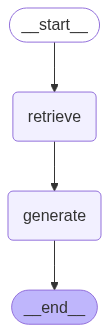

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
result = graph.invoke({"question": "what is the nutrition density of  cream cheese?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='7dedbb93-0b78-44fd-b999-874b2ffb874f', metadata={'row': 0.0, 'source': 'C:\\Users\\aravi\\Downloads\\archive (1)\\FINAL FOOD DATASET\\FOOD-DATA-GROUP1.csv', 'start_index': 0.0}, page_content=': 0\nUnnamed: 0: 0\nfood: cream cheese\nCaloric Value: 51\nFat: 5\nSaturated Fats: 2.9\nMonounsaturated Fats: 1.3\nPolyunsaturated Fats: 0.2\nCarbohydrates: 0.8\nSugars: 0.5\nProtein: 0.9\nDietary Fiber: 0\nCholesterol: 14.6\nSodium: 0.016\nWater: 7.6\nVitamin A: 0.2\nVitamin B1: 0.033\nVitamin B11: 0.064\nVitamin B12: 0.092\nVitamin B2: 0.097\nVitamin B3: 0.084\nVitamin B5: 0.052\nVitamin B6: 0.096\nVitamin C: 0.004\nVitamin D: 0\nVitamin E: 0\nVitamin K: 0.1\nCalcium: 0.008\nCopper: 14.1\nIron: 0.082\nMagnesium: 0.027\nManganese: 1.3\nPhosphorus: 0.091\nPotassium: 15.5\nSelenium: 19.1\nZinc: 0.039\nNutrition Density: 7.07'), Document(id='a3dbf7ea-bd4f-4418-bd19-e636401340a6', metadata={'row': 4.0, 'source': 'C:\\Users\\aravi\\Downloads\\archive (1)\\FINAL FOOD DATASET\\FOO